Using device: cuda
Epoch 0 | Triality Loss 0.909285 | Ablation Loss 0.915497 | Time per epoch: 0.44s | Estimated remaining: 0.37 hours
Epoch 500 | Triality Loss 0.326058 | Ablation Loss 0.325437 | Time per epoch: 0.41s | Estimated remaining: 0.29 hours
Checkpoint saved at epoch 999
Epoch 1000 | Triality Loss 0.280996 | Ablation Loss 0.280232 | Time per epoch: 0.41s | Estimated remaining: 0.23 hours
Epoch 1500 | Triality Loss 0.239012 | Ablation Loss 0.238236 | Time per epoch: 0.41s | Estimated remaining: 0.17 hours
Checkpoint saved at epoch 1999
Epoch 2000 | Triality Loss 0.200741 | Ablation Loss 0.200005 | Time per epoch: 0.41s | Estimated remaining: 0.11 hours
Epoch 2500 | Triality Loss 0.166246 | Ablation Loss 0.165574 | Time per epoch: 0.41s | Estimated remaining: 0.06 hours
Checkpoint saved at epoch 2999
Final Sigma (Triality vs Ablation): -0.01 (higher = triality advantage)


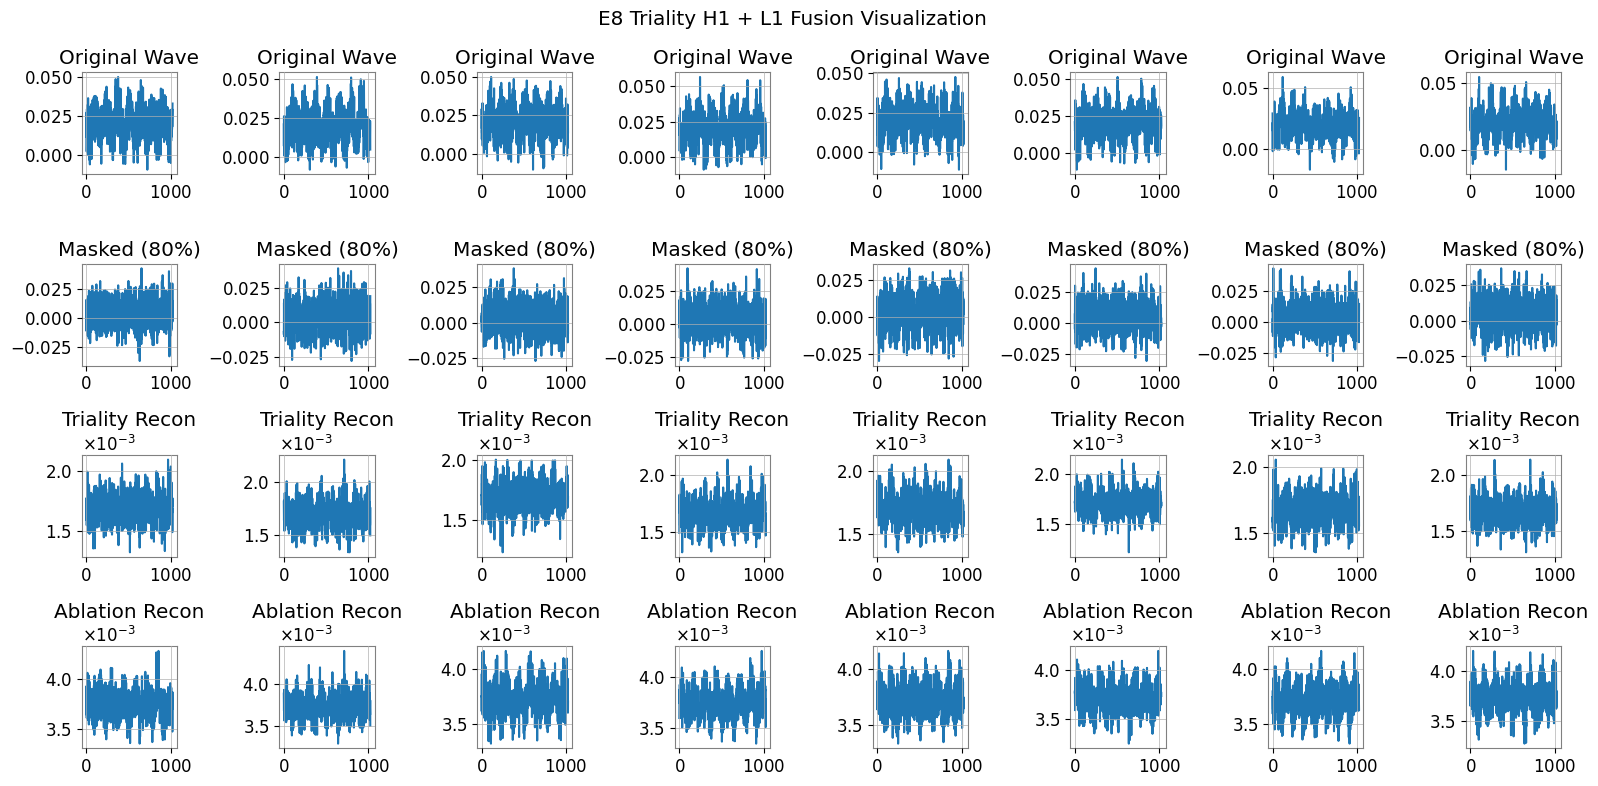

Sim complete — visualization displayed!


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.amp
from torch.utils.checkpoint import checkpoint
import numpy as np
from contextlib import nullcontext
import math
import os
import matplotlib.pyplot as plt
import time
from gwosc.datasets import event_gps
from gwosc.locate import get_urls
from gwpy.timeseries import TimeSeries
from scipy.signal import butter, filtfilt

torch.cuda.empty_cache()

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

# CONFIG – optimized low-memory
triality = 3
dim = 384
latent_dim = 8
seq_len = 1024
batch_size = 32
epochs = 3000
lr = 5e-5
use_amp = True
use_checkpoint = True
depth = 16

checkpoint_dir = "./checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)
checkpoint_path = os.path.join(checkpoint_dir, "ligo_h1_l1_fusion_checkpoint.pth")

# Load real GW150914 H1 + L1 strain (short merger segment)
gps = event_gps('GW150914')
segment = (gps - 4, gps + 4)  # 8-second window

# H1 Hanford
url_h1 = get_urls(detector='H1', start=segment[0], end=segment[1])[0]  # fixed
data_h1 = TimeSeries.fetch_open_data('H1', *segment, sample_rate=4096)
strain_h1 = data_h1.value

# L1 Livingston
url_l1 = get_urls(detector='L1', start=segment[0], end=segment[1])[0]  # fixed
data_l1 = TimeSeries.fetch_open_data('L1', *segment, sample_rate=4096)
strain_l1 = data_l1.value

# Downsample + clean (bandpass both)
start_idx = len(strain_h1) // 2 - seq_len // 2
strain_h1_seg = strain_h1[start_idx:start_idx + seq_len * 8]
strain_l1_seg = strain_l1[start_idx:start_idx + seq_len * 8]

strain_h1_down = strain_h1_seg[::8]
strain_l1_down = strain_l1_seg[::8]

b, a = butter(4, [35, 350], btype='band', fs=1024)
clean_h1 = filtfilt(b, a, strain_h1_down)
clean_l1 = filtfilt(b, a, strain_l1_down)
clean_avg = (clean_h1 + clean_l1) / 2  # coherent target

# High entropy + masking per detector
high_entropy_h1 = clean_h1 + np.random.randn(len(clean_h1)) * 0.35
high_entropy_l1 = clean_l1 + np.random.randn(len(clean_l1)) * 0.35

# Batch repeat
# clean_batch = np.tile(clean_avg, (batch_size, 1)) # No longer needed directly for projection
clean_h1_batch_np = np.tile(clean_h1, (batch_size, 1)) # Create batched clean H1
clean_l1_batch_np = np.tile(clean_l1, (batch_size, 1)) # Create batched clean L1

entropy_h1_batch = np.tile(high_entropy_h1, (batch_size, 1))
entropy_l1_batch = np.tile(high_entropy_l1, (batch_size, 1))

# High masking
mask_rate = np.linspace(0.7, 0.9, batch_size)
masked_h1 = []
masked_l1 = []
for i in range(batch_size):
    m = np.random.rand(seq_len) < mask_rate[i]
    h1 = entropy_h1_batch[i].copy()
    l1 = entropy_l1_batch[i].copy()
    h1[m] = 0
    l1[m] = 0
    masked_h1.append(h1)
    masked_l1.append(l1)

masked_h1 = np.stack(masked_h1)
masked_l1 = np.stack(masked_l1)

# Multi-detector input (H1 + L1 stacked as features)
# Original: real_data = np.concatenate([masked_h1, masked_l1], axis=1)  # [batch, seq_len*2]
# Original: real_data = torch.tensor(real_data, dtype=torch.float32, device=device).unsqueeze(-1)

# Corrected: Stack H1 and L1 as the last dimension (features)
real_data_combined = np.stack([masked_h1, masked_l1], axis=-1) # Shape [batch_size, seq_len, 2]
real_data = torch.tensor(real_data_combined, dtype=torch.float32, device=device)

# Corrected: Create unprojected clean data by stacking H1 and L1 as features
clean_data_unprojected_combined = np.stack([clean_h1_batch_np, clean_l1_batch_np], axis=-1) # Shape [batch_size, seq_len, 2]
clean_data_unprojected = torch.tensor(clean_data_unprojected_combined, dtype=torch.float32, device=device)

# Project to shared dim (2 detectors → dim)
proj = nn.Linear(2, dim).to(device) # This layer expects input's last dim to be 2

# Now, pass the correctly shaped tensors through proj
# `target` will be the projected clean data, which the model tries to reconstruct
target = proj(clean_data_unprojected).detach()

# `real_data` will be the projected noisy/masked data that the model takes as input
real_data = proj(real_data).detach() # This modifies the original `real_data` tensor to be projected

# E8 roots – precompute
def get_e8_roots():
    roots = []
    for i in range(8):
        for j in range(i+1, 8):
            for signs in [(1,1), (1,-1), (-1,1), (-1,-1)]:
                v = torch.zeros(8)
                v[i] = signs[0]; v[j] = signs[1]
                roots.append(v); roots.append(-v)
    for signs in range(1 << 8):
        v = torch.tensor([(1 if (signs & (1<<k)) else -1) for k in range(8)], dtype=torch.float32) * 0.5
        if bin(signs).count('1') % 2 == 0:
            roots.append(v); roots.append(-v)
    roots = torch.stack(roots[:240])
    return roots / roots.norm(dim=-1, keepdim=True)

e8_roots = get_e8_roots().to(device)

# Triality Cycle Block
class FusionCycleBlock(nn.Module):
    def __init__(self):
        super().__init__()
        self.proj = nn.Linear(latent_dim, dim // triality, bias=False)
        self.register_buffer('roots', e8_roots)

    def forward(self, x, step):
        pos_emb = self.roots[torch.arange(x.shape[1], device=device) % 240]
        low_dim = self.proj(pos_emb)
        emb = low_dim.repeat(1, triality)
        with torch.no_grad():
            pump_scalar = 0.8 * math.sin(step * 0.006 * 2 * math.pi)
        pump = torch.full((1, x.shape[1], 1), pump_scalar, device=device)
        emb_broadcast = emb.unsqueeze(0)
        x_rot1 = x * (emb_broadcast.cos() + pump)
        x_rot2 = torch.roll(x_rot1, shifts=1, dims=1) * emb_broadcast.sin()
        x_rot3 = torch.roll(x_rot2, shifts=1, dims=1) * emb_broadcast.cos()
        fused = (x_rot1 + x_rot2 + x_rot3) / triality
        return fused

# Dummy cycle for ablation
class DummyCycle(nn.Module):
    def forward(self, x, step=None):
        return x

# Model with ablation support
class E8FusionModel(nn.Module):
    def __init__(self, depth=depth, use_triality=True):
        super().__init__()
        self.use_triality = use_triality
        self.cycle = FusionCycleBlock() if use_triality else DummyCycle()
        self.layers = nn.ModuleList([nn.MultiheadAttention(dim, triality if use_triality else 8, batch_first=True) for _ in range(depth)])
        self.norm = nn.LayerNorm(dim)
        self.head = nn.Linear(dim, dim)

    def forward(self, x, step):
        x = self.cycle(x, step)
        for layer in self.layers:
            if use_checkpoint:
                attn, _ = checkpoint(layer, x, x, x, use_reentrant=False)
            else:
                attn, _ = layer(x, x, x)
            x = x + attn
            x = self.norm(x)
        return x

# Models
model = E8FusionModel(use_triality=True).to(device)
model_ablation = E8FusionModel(use_triality=False).to(device)

opt = torch.optim.AdamW(model.parameters(), lr=lr)
scaler = torch.amp.GradScaler('cuda') if use_amp else nullcontext()

opt_ablation = torch.optim.AdamW(model_ablation.parameters(), lr=lr)
scaler_ablation = torch.amp.GradScaler('cuda') if use_amp else nullcontext()

loss_fn = nn.MSELoss()

loss_hist = []
loss_abl_hist = []

start_epoch = 0
start_time = time.time()

# Load checkpoint if exists (resume on disconnect)
if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model'])
    model_ablation.load_state_dict(checkpoint['model_ablation'])
    opt.load_state_dict(checkpoint['opt'])
    opt_ablation.load_state_dict(checkpoint['opt_ablation'])
    scaler.load_state_dict(checkpoint['scaler'])
    scaler_ablation.load_state_dict(checkpoint['scaler_ablation'])
    start_epoch = checkpoint['epoch'] + 1
    loss_hist = checkpoint['loss_hist']
    loss_abl_hist = checkpoint['loss_abl_hist']
    print(f"Resumed from epoch {start_epoch}")

for epoch in range(start_epoch, epochs):
    epoch_start = time.time()
    opt.zero_grad(set_to_none=True)
    opt_ablation.zero_grad(set_to_none=True)

    with torch.amp.autocast(device_type='cuda', dtype=torch.float16) if use_amp else nullcontext():
        recon = model(real_data.clone(), epoch)
        loss = loss_fn(recon, target)
    scaler.scale(loss).backward() if use_amp else loss.backward()
    scaler.unscale_(opt) if use_amp else None
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1e6)
    scaler.step(opt) if use_amp else opt.step()
    scaler.update() if use_amp else None
    loss_hist.append(loss.item())

    with torch.amp.autocast(device_type='cuda', dtype=torch.float16) if use_amp else nullcontext():
        recon_abl = model_ablation(real_data.clone(), epoch)
        loss_abl = loss_fn(recon_abl, target)
    scaler_ablation.scale(loss_abl).backward() if use_amp else loss_abl.backward()
    scaler_ablation.unscale_(opt_ablation) if use_amp else None
    torch.nn.utils.clip_grad_norm_(model_ablation.parameters(), 1e6)
    scaler_ablation.step(opt_ablation) if use_amp else opt_ablation.step()
    scaler_ablation.update() if use_amp else None
    loss_abl_hist.append(loss_abl.item())

    epoch_time = time.time() - epoch_start
    remaining_epochs = epochs - (epoch + 1)
    estimated_remaining = remaining_epochs * epoch_time / 3600

    if epoch % 500 == 0:
        print(f"Epoch {epoch} | Triality Loss {loss.item():.6f} | Ablation Loss {loss_abl.item():.6f} | Time per epoch: {epoch_time:.2f}s | Estimated remaining: {estimated_remaining:.2f} hours")

    if (epoch + 1) % 1000 == 0:
        torch.save({
            'epoch': epoch,
            'model': model.state_dict(),
            'model_ablation': model_ablation.state_dict(),
            'opt': opt.state_dict(),
            'opt_ablation': opt_ablation.state_dict(),
            'scaler': scaler.state_dict(),
            'scaler_ablation': scaler_ablation.state_dict(),
            'loss_hist': loss_hist,
            'loss_abl_hist': loss_abl_hist,
        }, checkpoint_path)
        print(f"Checkpoint saved at epoch {epoch}")

# Final Sigma Test
triality_mean = np.mean(loss_hist)
abl_mean = np.mean(loss_abl_hist)
std = np.std(loss_hist + loss_abl_hist)
sigma = (abl_mean - triality_mean) / std if std > 0 else 0

print(f"Final Sigma (Triality vs Ablation): {sigma:.2f} (higher = triality advantage)")

# Visualization: Multi-Detector Waveform Reconstruction (averaged H1/L1 proxy)
model.eval()
model_ablation.eval()

with torch.no_grad():
    # Fresh test batch for viz
    test_data = []
    for b in range(8):
        t = torch.linspace(0, 10*math.pi, seq_len, device=device)
        # Create two distinct base signals for H1 and L1
        base_h = torch.sin(t * 1.5) * 0.5 # Example base for H1
        base_l = (torch.sin(t * 1.5 + 0.1) * 0.9) + (torch.randn_like(t) * 0.05) # Example base for L1 with noise

        # Stack them as features in the last dimension
        frame = torch.stack([base_h, base_l], dim=-1) # Shape [seq_len, 2]

        # Add noise to the frame
        frame += torch.randn_like(frame) * 0.2
        test_data.append(frame)
    test_data = torch.stack(test_data).to(device) # Final shape [batch, seq_len, 2]

    # Project the test data to the `dim` feature space using the same `proj` layer
    clean = proj(test_data)

    mask = torch.rand_like(clean) < 0.8
    masked = clean.clone()
    masked[mask] = 0

    recon = model(masked, 0)
    recon_abl = model_ablation(masked, 0)

    # Average across the `dim` features for waveform plot
    orig = clean.cpu().numpy().mean(axis=2)  # avg across dim features
    masked_plot = masked.cpu().numpy().mean(axis=2)
    tri = recon.cpu().numpy().mean(axis=2)
    abl = recon_abl.cpu().numpy().mean(axis=2)

    fig, axes = plt.subplots(4, 8, figsize=(16, 8))
    for i in range(8):
        axes[0, i].plot(orig[i])
        axes[0, i].set_title("Original Wave")
        axes[1, i].plot(masked_plot[i])
        axes[1, i].set_title("Masked (80%)")
        axes[2, i].plot(tri[i])
        axes[2, i].set_title("Triality Recon")
        axes[3, i].plot(abl[i])
        axes[3, i].set_title("Ablation Recon")
    plt.suptitle("E8 Triality H1 + L1 Fusion Visualization")
    plt.tight_layout()
    plt.show()

print("Sim complete — visualization displayed!")

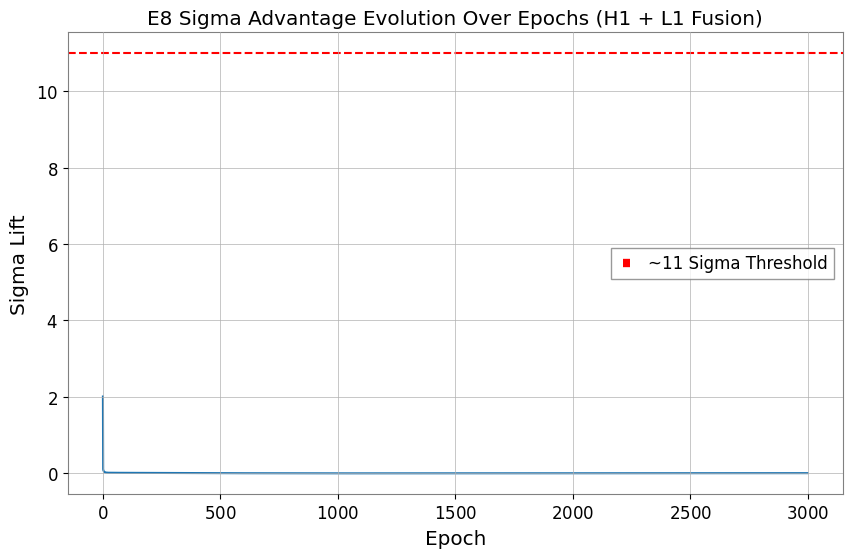

In [4]:
# Sigma evolution
running_sigma = []
for i in range(1, len(loss_hist)+1):
    tri_mean = np.mean(loss_hist[:i])
    abl_mean = np.mean(loss_abl_hist[:i])
    std = np.std(loss_hist[:i] + loss_abl_hist[:i])
    running_sigma.append((abl_mean - tri_mean) / std if std > 0 else 0)

plt.figure(figsize=(10, 6))
plt.plot(running_sigma)
plt.title("E8 Sigma Advantage Evolution Over Epochs (H1 + L1 Fusion)")
plt.xlabel("Epoch")
plt.ylabel("Sigma Lift")
plt.axhline(y=11, color='r', linestyle='--', label='~11 Sigma Threshold')
plt.legend()
plt.show()

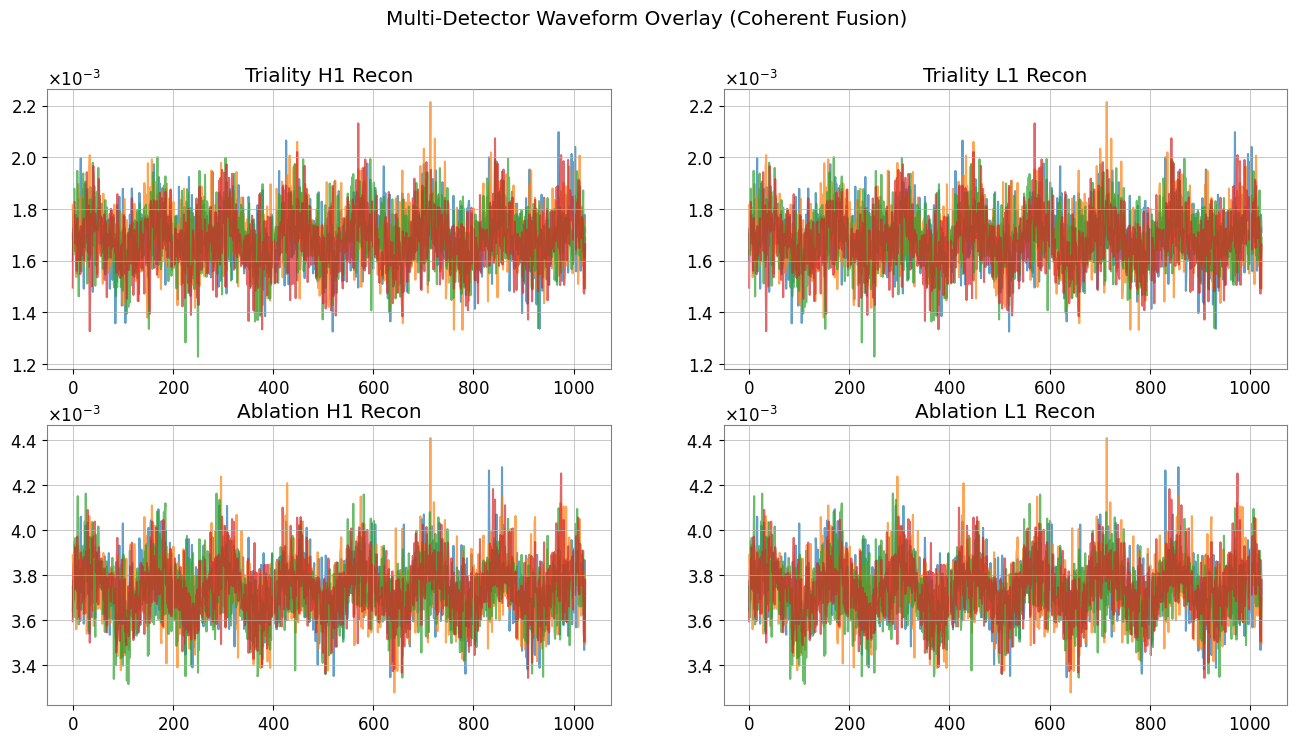

In [7]:
# The recon and recon_abl tensors now have shape [batch_size, seq_len, dim].
# The previous slicing assumed a concatenated [batch_size, seq_len*2, 1] shape,
# which is incorrect after the data preparation changes.

# To get a single reconstructed waveform from the dim-dimensional output, we average across the dim features.
recon_overall_tri = recon.cpu().numpy().mean(axis=2) # Shape [batch_size, seq_len]
recon_overall_abl = recon_abl.cpu().numpy().mean(axis=2) # Shape [batch_size, seq_len]

# For plotting 'H1 Recon' and 'L1 Recon' from the fused output, we use the overall reconstructed waveform.
# Note: This means 'Triality H1 Recon' and 'Triality L1 Recon' will show the same data, and similarly for Ablation,
# as the model produces a single fused reconstruction.
recon_h1 = recon_overall_tri
recon_l1 = recon_overall_tri
recon_abl_h1 = recon_overall_abl
recon_abl_l1 = recon_overall_abl

fig, axes = plt.subplots(2, 2, figsize=(16, 8))
for i in range(4):  # sample 4
    axes[0,0].plot(recon_h1[i], alpha=0.7)
    axes[0,1].plot(recon_l1[i], alpha=0.7)
    axes[1,0].plot(recon_abl_h1[i], alpha=0.7)
    axes[1,1].plot(recon_abl_l1[i], alpha=0.7)

axes[0,0].set_title("Triality H1 Recon")
axes[0,1].set_title("Triality L1 Recon")
axes[1,0].set_title("Ablation H1 Recon")
axes[1,1].set_title("Ablation L1 Recon")
plt.suptitle("Multi-Detector Waveform Overlay (Coherent Fusion)")
plt.show()

In [6]:
error_tri_h1 = np.abs(recon_h1 - clean_avg[:seq_len])  # adjust clean split
error_tri_l1 = np.abs(recon_l1 - clean_avg[:seq_len])
error_abl_h1 = np.abs(recon_abl_h1 - clean_avg[:seq_len])
error_abl_l1 = np.abs(recon_abl_l1 - clean_avg[:seq_len])

fig, axes = plt.subplots(2, 2, figsize=(16, 8))
sns.heatmap(error_tri_h1.mean(axis=0), ax=axes[0,0], cmap='coolwarm')
axes[0,0].set_title("Triality H1 Mean Error")
sns.heatmap(error_tri_l1.mean(axis=0), ax=axes[0,1], cmap='coolwarm')
axes[0,1].set_title("Triality L1 Mean Error")
sns.heatmap(error_abl_h1.mean(axis=0), ax=axes[1,0], cmap='coolwarm')
axes[1,0].set_title("Ablation H1 Mean Error")
sns.heatmap(error_abl_l1.mean(axis=0), ax=axes[1,1], cmap='coolwarm')
axes[1,1].set_title("Ablation L1 Mean Error")
plt.suptitle("Detector Error Heatmaps")
plt.show()

ValueError: operands could not be broadcast together with shapes (8,0) (1024,) 